![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from sklearn import metrics

In [83]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [ ]:
# Celda 1.1
df_season = bikes.groupby('season').total.mean()

In [84]:
# Estadisticas descriptivas por estación
season_stats = bikes.groupby('season').total.agg(['mean', 'max', 'min', 'std',
                                                  lambda x: x.quantile(0.25),
                                                  lambda x: x.quantile(0.5),
                                                  lambda x: x.quantile(0.75)])
season_stats.columns = ['mean', 'max', 'min', 'std', 'percentil_25', 'percentil_50', 'percentil_75']
season_stats

,mean,max,min,std,percentil_25,percentil_50,percentil_75
season,,,,,,,
1,116.343261,801,1,125.273974,24.0,78.0,164.0
2,215.251372,873,1,192.007843,49.0,172.0,321.0
3,234.417124,977,1,197.151001,68.0,195.0,347.0
4,198.988296,948,1,177.622409,51.0,161.0,294.0


<p style="text-align: justify;">
Se observa que el promedio de bicicletas rentadas varía notablemente entre estaciones. El verano (*season*= 3) presenta la media más alta con 234 bicicletas rentadas en promedio, seguido por otoño (215), primavera (199) y finalmente invierno con la media más baja (116). Esto sugiere una mayor demanda de bicicletas en estaciones cálidas, probablemente por condiciones climáticas más favorables. La dispersión también aumenta en las estaciones más cálidas, como se evidencia en los valores de desviación estándar, que alcanzan su máximo en verano (197). Además, durante la temporada de inverno se observan valores bajos en los percentiles 25 (24) y 50 (78), lo que refuerza la idea de una menor demanda en esta temporada. En conjunto, los datos reflejan una estacionalidad clara en el uso de bicicletas, con una mayor actividad en los meses de verano y primavera. <p>

In [85]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [86]:
# Estadisticas descriptivas por estación
hour_stats = bikes.groupby('hour').total.agg(['mean', 'max', 'min', 'std',
                                                  lambda x: x.quantile(0.25),
                                                  lambda x: x.quantile(0.5),
                                                  lambda x: x.quantile(0.75)])
hour_stats.columns = ['mean', 'max', 'min', 'std', 'percentil_25', 'percentil_50', 'percentil_75']
hour_stats

,mean,max,min,std,percentil_25,percentil_50,percentil_75
hour,,,,,,,
0,55.138462,283,2,43.620012,24.00,41.0,74.50
1,33.859031,168,1,34.112105,11.00,19.0,46.00
2,22.899554,119,1,26.110267,5.00,11.0,32.00
3,11.757506,66,1,12.666442,3.00,6.0,15.00
4,6.407240,28,1,4.217633,3.00,6.0,9.00
5,19.767699,57,1,12.784293,8.00,19.0,29.00
6,76.259341,213,1,54.745333,24.50,75.0,118.00
7,213.116484,596,1,159.207044,63.00,208.0,334.00
8,362.769231,839,8,231.723065,133.50,392.0,563.50


<p style="text-align: justify;">
En cuanto al promedio de bicicletas rentadas por hora, se observa un uso muy bajo entre la medianoche y las 5 a.m. A partir de las 6 a.m., el uso aumenta, alcanzando su primer pico a las 8 a.m. (promedio de 362). Luego, disminuye ligeramente y vuelve a subir a partir del mediodía, con el mayor uso a las 5 p.m. registrando un promedio de 468. Este comportamiento refleja claramente los horarios laborales. <p>

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

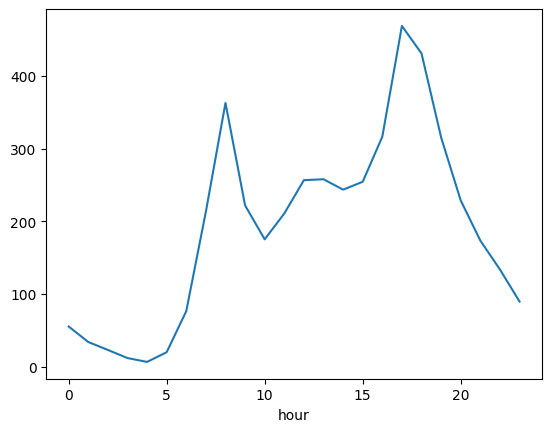

In [87]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

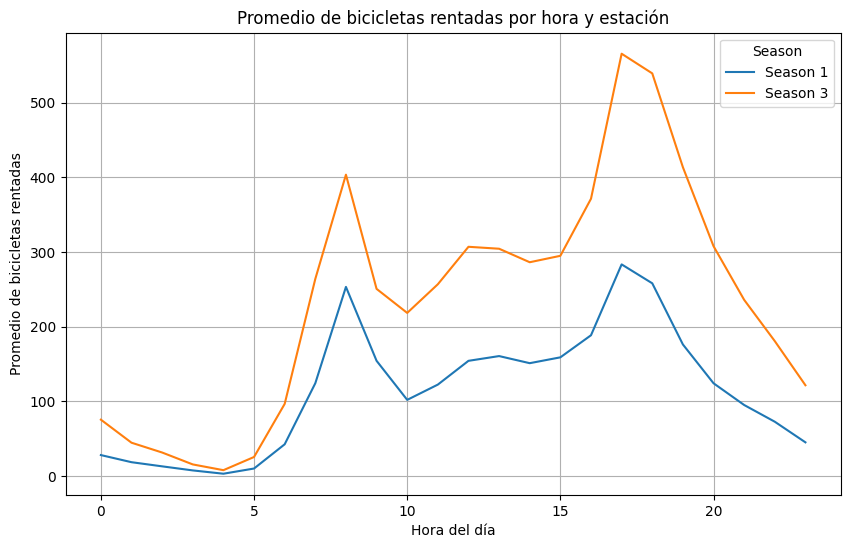

In [88]:
# Gráfico número de bicicletas por hora para las estaciones de verano e invierno
plt.figure(figsize=(10, 6))

# Graficar para cada 'season'
for season in [1, 3]:
    # Filtrar por 'season' y calcular el promedio por 'hour'
    hourly_avg = bikes[bikes['season'] == season].groupby('hour').total.mean()
    # Graficar la línea
    plt.plot(hourly_avg.index, hourly_avg.values, label=f'Season {season}')

# Personalizar el gráfico
plt.title('Promedio de bicicletas rentadas por hora y estación')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas rentadas')
plt.legend(title='Season')
plt.grid(True)
plt.show()

<p style="text-align: justify;">
Al analizar el promedio de bicicletas rentadas por hora, se observa que durante la temporada de verano (*season* = 3) la demanda es consistentemente superior a la registrada en invierno (*season* = 1), sin importar la franja horaria. Esta diferencia general sugiere una mayor disposición al uso de bicicletas en los meses cálidos, probablemente por condiciones climáticas más favorables.

Además, el comportamiento horario muestra una clara estacionalidad en ambas temporadas, con dos picos bien definidos: uno en la mañana, a las 8:00 a.m., y otro en la tarde, a las 5:00 p.m. Estos picos coinciden con las horas típicas de desplazamiento hacia y desde el trabajo o estudio, lo que indica un uso funcional del sistema de bicicletas compartidas.

Un aspecto notable es que, aunque la demanda es mayor en verano a lo largo del día, la diferencia entre ambas temporadas se acentúa especialmente en el pico de la tarde, alrededor de las 5:00 p.m., mucho más que en el pico de la mañana a las 8:00 a.m. Esto podría reflejar una mayor preferencia por actividades recreativas al final de la jornada en verano.<p>

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

En principio, se define la variable *season* como categorica usando *pd.get_dummies()* y se modifican a tipo integer. Adicionalmente, es de resaltar que se elimina la categoria de invierno (*season*=1) con el objetivo de evitar multicolinelaidad en el modelo:

In [89]:
# Convertir la variable "season" a categórica
bikes_dummies = pd.get_dummies(bikes, columns=['season'], drop_first=True)
bikes_dummies[['season_2', 'season_3', 'season_4']] = bikes_dummies[['season_2', 'season_3', 'season_4']].astype(int)

# Visualización de los datos
bikes_dummies.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,1,9.84,14.395,81,0.0,3,13,16,0,0,0,0
2011-01-01 01:00:00,0,0,1,9.02,13.635,80,0.0,8,32,40,1,0,0,0
2011-01-01 02:00:00,0,0,1,9.02,13.635,80,0.0,5,27,32,2,0,0,0
2011-01-01 03:00:00,0,0,1,9.84,14.395,75,0.0,3,10,13,3,0,0,0
2011-01-01 04:00:00,0,0,1,9.84,14.395,75,0.0,0,1,1,4,0,0,0


In [90]:
# Definir variables predictoras y variable objetivo
X = bikes_dummies[['hour','season_2', 'season_3', 'season_4']]  # 'season=1' se omite por drop_first
y = bikes_dummies['total']

In [91]:
# Separación de los datos en entrenamiento y prueba
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.33, random_state=0)

In [92]:
# Creación de constante para el modelo OLS
X_Train_ols = sm.add_constant(XTrain)
# Ajuste de modelo OLS
model_ols = sm.OLS(yTrain, X_Train_ols).fit()

# Predicciones con el modelo OLS
y_pred_ols = model_ols.predict(sm.add_constant(XTest))

# Evaluación del modelo OLS
MSE_OLS = mean_squared_error(yTest, y_pred_ols)

In [93]:
# Resumen del modelo OLS
print(model_ols.summary())
print(f'Error cuadrático medio del modelo OLS: {MSE_OLS}')

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     534.9
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:36:46   Log-Likelihood:                -47334.
No. Observations:                7293   AIC:                         9.468e+04
Df Residuals:                    7288   BIC:                         9.471e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.5631      4.873     -1.962      0.0

**Interpretación de Coeficientes** <br>
Antes de comenzar la interpretación de coeficientes, es de resaltar que la variable *season* se dividió en 3 variables *dummies* que toman valores de 0 y 1. Se excluyó la primera categoría correspondiente a la estación de invierno. Por consiguiente los coeficientes a analizar serán: *intercepto, hour, season_2, season_3, season_4*

- *intercepto*: segun los resultados en promedio la demanda de bicicletas disminuye en 9.5 unidades durante la estación de invierno. <br>
- *hour*:Ante un incremento de una unidad en la variable *hour* la renta de bicicletas crece en 10 unidades manteniendo todo lo demás constante. <br>
- *season_2*: En promedio estar en primavera (*season*=2) se asocia con un incremento en la renta de bicicletas de 100.9 unidades en comparación con invierno que es la categoría base (*season*=1).
- *season_3*: En promedio estar en verano (*season*=3) se asocia con un incremento en la renta de bicicletas de 119 unidades en comparación con invierno que es la categoría base (*season*=1).
- *season_4*: En promedio estar en otoño (*season*=4) se asocia con un incremento en la renta de bicicletas de 87 unidades en comparación con invierno que es la categoría base (*season*=1).

**¿Cuáles son las limitaciones de la regresión lineal en este caso?**

<p style="text-align: justify;">
El modelo de Mínimos Cuadrados Ordinarios (OLS) se basa en una serie de supuestos que, si se violan, pueden comprometer la validez de sus estimaciones. Una de las principales limitaciones se relaciona con la homoscedasticidad: la varianza constante de los errores a lo largo del rango de predicciones. La gráfica de residuos que se presenta a continuación evidencia heteroscedasticidad, ya que la dispersión de los residuos aumenta conforme crecen las predicciones. La heteroscedaticidad puede invalidar la inferencia estadística y generar predicciones poco confiables. Adicionalmente, se observa como la varianza de los residuos aumento conforme aumentan las predicciones, sugieriendo que el modelo podría estar omitiendo una relación no lineal entre las variables, lo que también va en contra del supuesto de linealidad en los parámetros en el modelo de regresión lineal. <p>

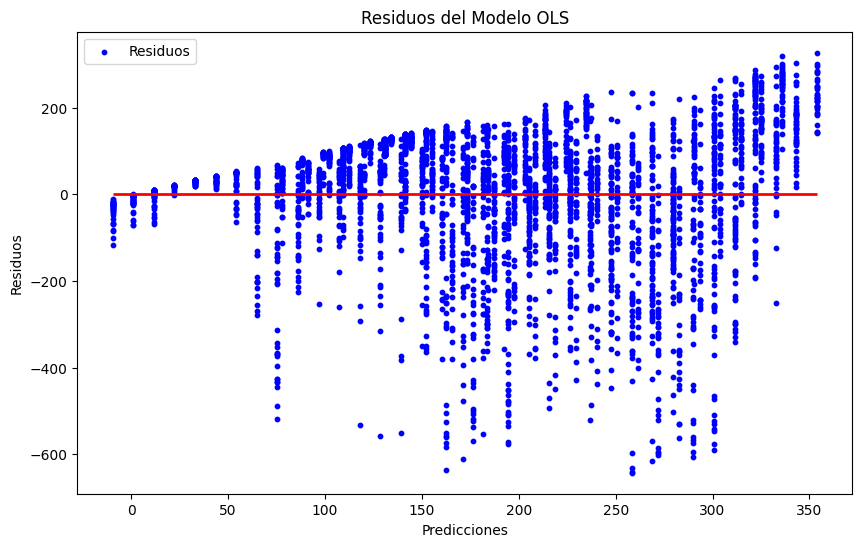

In [94]:
# Gráfico de residuos del modelo OLS
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ols, y_pred_ols - yTest, color='blue', s=10, label='Residuos')
plt.hlines(y=0, xmin=y_pred_ols.min(), xmax=y_pred_ols.max(), color='red', lw=2)
plt.title('Residuos del Modelo OLS')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.legend()
plt.show()

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

### 4.1. Creación de Funciones

In [ ]:
# Definición de función para calcular la varianza
def variance(y):
    """
    Esta función calcula la varianza de una variable de respuesta discreta.
    """
    if y.shape[0] == 0:
        return 0
    else:
        return y.var()

In [96]:
# Definición de la función variance_impurity para calular la reducción de la varianza de una variable predictora j dado el punto de corte k
def variance_impurity(X_col, y, split):
    """
    Calcula la reducción de varianza al dividir el conjunto de datos en dos subconjuntos.
    """
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    var_y = variance(y)
    var_l = variance(y_l)
    var_r = variance(y_r)

    # Reducción de varianza
    variance_reduction = var_y - (n_l / (n_l + n_r) * var_l + n_r / (n_l + n_r) * var_r)

    return variance_reduction

In [ ]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y):
    """
    Encuentra la mejor variable y punto de corte para dividir los datos.
    Los puntos de corte son todos los valores únicos de las variables incluidas.
    """
    features = range(X.shape[1])  # Índices de las columnas de X
    best_split = [0, 0, 0]  # j, split, gain

    # Iterar sobre todas las variables
    for j in features:
        # Obtener los valores únicos de la variable j
        splits = np.unique(X.iloc[:, j])

        # Iterar sobre cada posible punto de corte
        for split in splits:
            gain = variance_impurity(X.iloc[:, j], y, split)

            # Actualizar el mejor split si la ganancia es mayor
            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

In [153]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean()) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth)
    
    return tree

In [ ]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [159]:
# Definición de una función para contar el número de nodos finales
def count_leaf(tree):
    """
    Cuenta recursivamente la cantidad de nodos finales en el árbol.
    """
    if tree['split'] == -1:
        return 1
    return count_leaf(tree['sl']) + count_leaf(tree['sr'])

### 4.2. Entrenamiento, predicción y evaluación de un árbol de decisión creado manualmente

In [155]:
# Definicion de variables predictoras y variable objetivo
XDecisionTree = bikes[['season', 'hour']]
yDecisionTree = bikes['total']
# Visualización de los datos
XDecisionTree.head()

,season,hour
datetime,,
2011-01-01 00:00:00,1,0
2011-01-01 01:00:00,1,1
2011-01-01 02:00:00,1,2
2011-01-01 03:00:00,1,3
2011-01-01 04:00:00,1,4


In [156]:
# Separación de los datos en entrenamiento y prueba
XTrain, XTest, yTrain, yTest = train_test_split(XDecisionTree, yDecisionTree, test_size=0.33, random_state=0)

In [161]:
# Entrenamiento del árbol de decisión
tree = tree_grow(XTrain, yTrain, level=0, min_gain=0.001, max_depth=6)
tree

# Predicciones con el árbol de decisión
y_pred_tree = tree_predict(XTest, tree, proba=True)
# Evaluación del árbol de decisión
MSE_ManualTree = mean_squared_error(yTest, y_pred_tree)

In [158]:
# Visualización resultado evaluación arbol de decisión
print(f"MSE Árbol de Decisión Manual: {MSE_ManualTree:.4f}")

MSE Árbol de Decisión Manual: 13649.6319


In [162]:
# Conteo de nodos finales
print(f"Cantidad de nodos finales: {count_leaf(tree)}")

Cantidad de nodos finales: 41


<p style="text-align: justify;">
En esta etapa se construyó manualmente un árbol de decisión. Para determinar la mejor variable y punto de corte, se implementó la función best_split, la cual utiliza la reducción en la varianza como criterio para medir la ganancia obtenida al dividir en un determinado punto sobre una variable *𝑗*. Posteriormente, se entrenó el modelo definiendo una profundidad máxima de 6. Finalmente, se realizaron las predicciones y se utilizó el error cuadrático medio (MSE) como métrica para evaluar el desempeño del modelo. <p>

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

### 5.1. Entrenamiento y Evaluación del Modelo

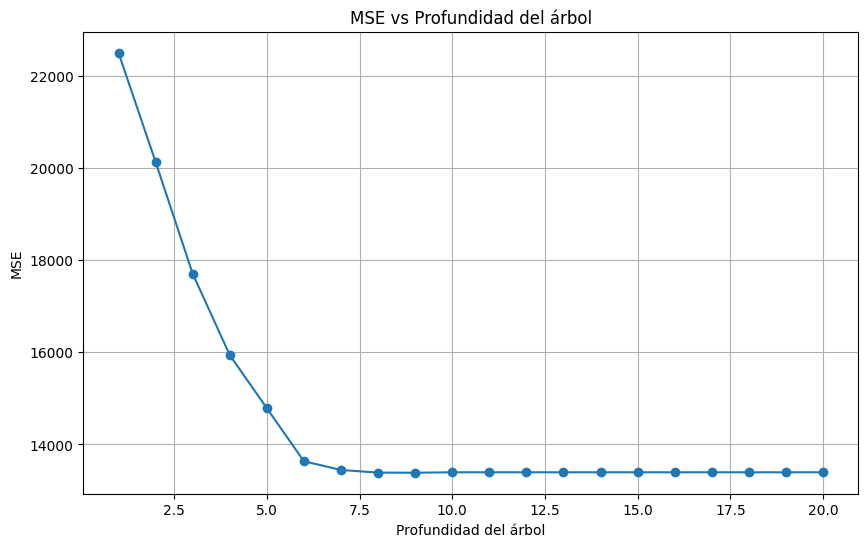

Profundidad óptima del árbol: 9


In [107]:
# Calibracion del parametro max_depth
depths = np.arange(1, 21)
MSEs = []
for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, min_samples_split=2, min_samples_leaf=1, random_state=0)
    model.fit(XTrain, yTrain)
    y_pred = model.predict(XTest)
    MSEs.append(mean_squared_error(yTest, y_pred))
# Gráfico de MSE vs profundidad
plt.figure(figsize=(10, 6))
plt.plot(depths, MSEs, marker='o')
plt.title('MSE vs Profundidad del árbol')
plt.xlabel('Profundidad del árbol')
plt.ylabel('MSE')
plt.grid()
plt.show()

# Profundidad óptima del árbol
optimal_depth = depths[np.argmin(MSEs)]
print(f'Profundidad óptima del árbol: {optimal_depth}')

MSE del árbol de decisión: 13385.87823424595
R2 del árbol de decisión: 0.5903380521577195


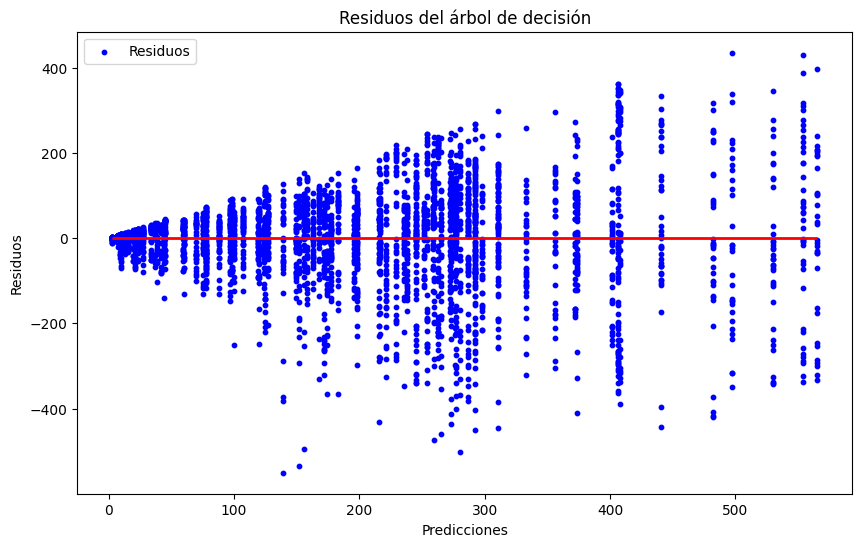

In [108]:
# Entrenamiento del árbol de decisión con profundidad óptima
model = DecisionTreeRegressor(max_depth=optimal_depth, min_samples_split=2, min_samples_leaf=1, random_state=0)
model.fit(XTrain, yTrain)
# Predicciones con el árbol de decisión
y_pred = model.predict(XTest)
# Evaluación del árbol de decisión
MSE_DecisionTree = mean_squared_error(yTest, y_pred)
print(f'MSE del árbol de decisión: {MSE_DecisionTree}')
print(f'R2 del árbol de decisión: {r2_score(yTest, y_pred)}')
# Gráfico de residuos del árbol de decisión
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_pred - yTest, color='blue', s=10, label='Residuos')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', lw=2)
plt.title('Residuos del árbol de decisión')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.legend()
plt.show()


### 5.2. Comparación de Modelos

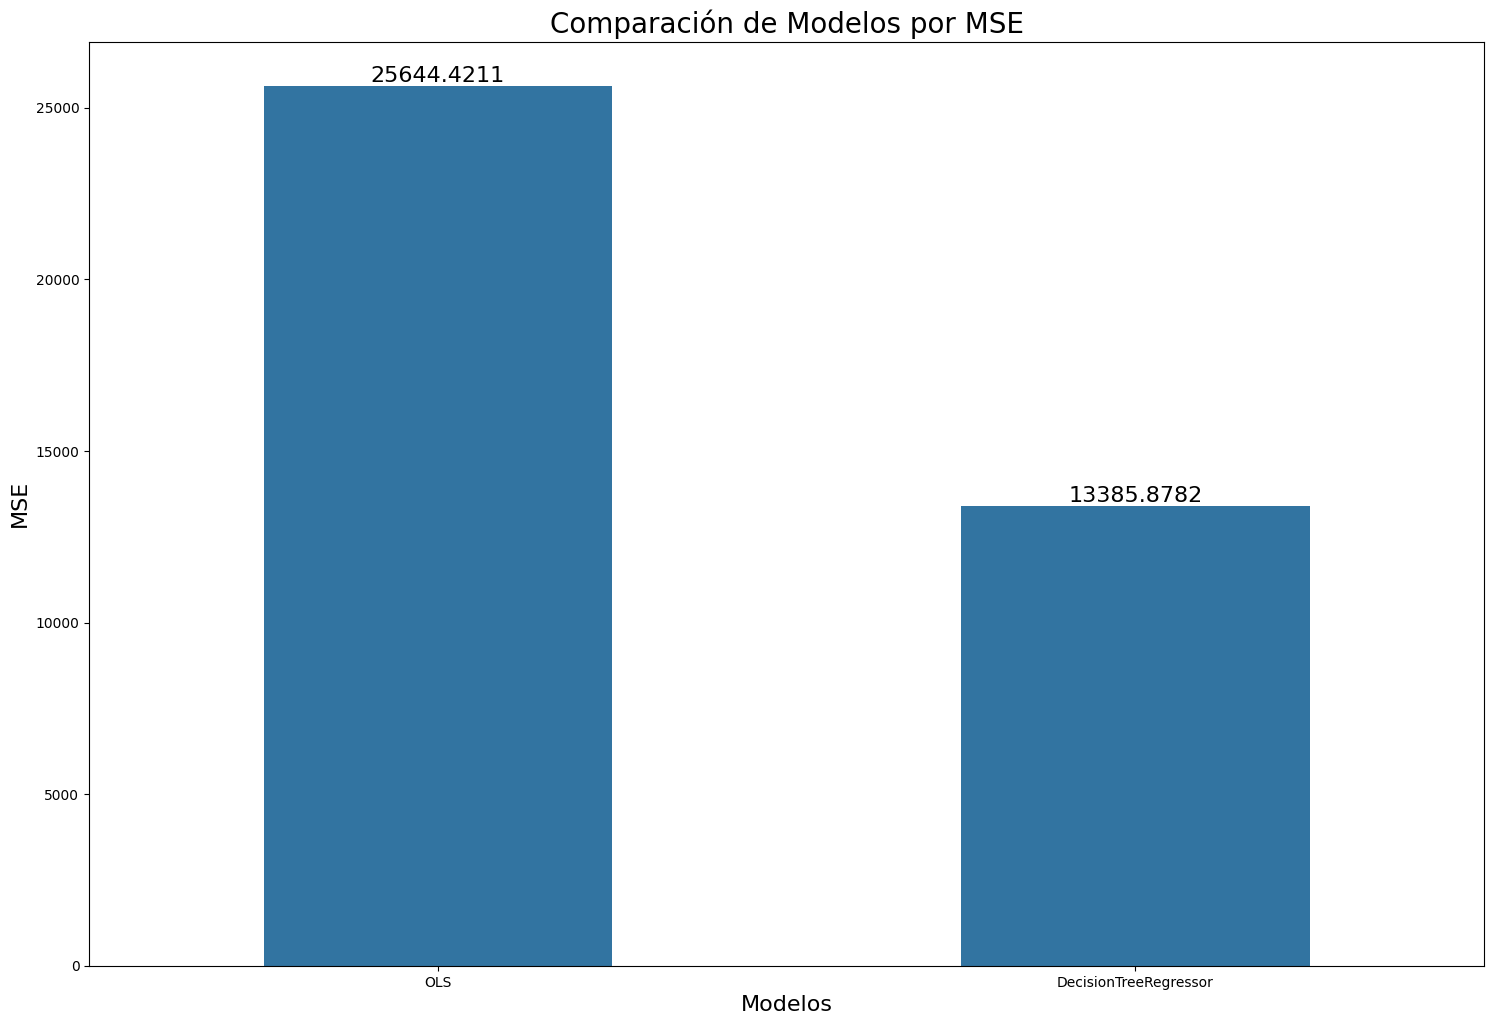

In [111]:
modelos = ['OLS', 'DecisionTreeRegressor']
MSE = [MSE_OLS, MSE_DecisionTree]

# Crear subplots
fig, axs = plt.subplots(1, 1, figsize=(18, 12))

# Gráfico 1: Comparar modelos por MSE
sns.barplot(x=modelos, y=MSE, ax=axs, width=0.5)
axs.set_title('Comparación de Modelos por MSE', fontsize=20)
axs.set_xlabel('Modelos', fontsize=16)
axs.set_ylabel('MSE', fontsize=16)
for i in range(len(modelos)):
    axs.text(i, MSE[i], round(MSE[i], 4), ha='center', va='bottom', fontsize=16, color='black')

<p style="text-align: justify;">
Se compara el desempeño de los modelos usando la métrica del error cuadrático medio (MSE). Como se puede observar en la gráfica presentada, el modelo de árbol de decisión (DecisionTreeRegressor) supera en desempeño al modelo de regresión lineal por Mínimos Cuadrados Ordinarios (OLS). Mientras que el OLS alcanza un MSE de aproximadamente 25,644, el árbol de decisión reduce este valor a cerca de 13,386, lo cual representa una mejora significativa en la capacidad predictiva.<p>

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [112]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [113]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [114]:
# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

### 6.1. Árbol de decisión

En primer lugar se calibra el parámetro max_depth de un modelo de árbol de decisión para clasificación, evaluando profundidades de 1 a 20. Para cada valor se entrena el modelo, se realizan predicciones y se calculan las métricas de accuracy y F1-score.

In [116]:
# Calibración del parámetros max_depth en un modelos de árbol de decisión en clasificacion
depths = np.arange(1, 21)
accuracy = []
f1_scores = []
for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, min_samples_split=2, min_samples_leaf=1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

Posteriormente, se grafican las métricas de desempeño y se selecciona la produndidad óptima según cada una de ellas:

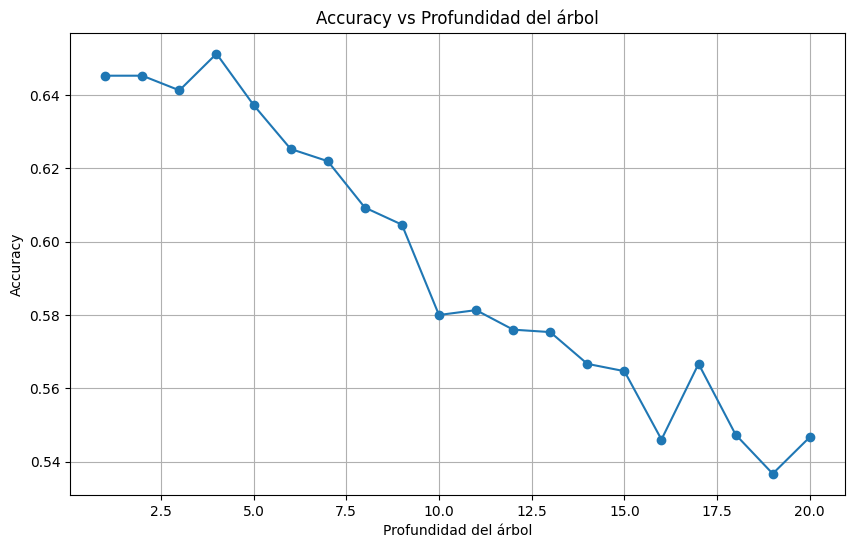

Profundidad óptima del árbol según Accuracy: 4


In [119]:
# Gráfico de accuracy vs profundidad
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracy, marker='o')
plt.title('Accuracy vs Profundidad del árbol')
plt.xlabel('Profundidad del árbol')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

# Profundidad óptima del árbol
optimal_depth_accuracy = depths[np.argmax(accuracy)]
print(f'Profundidad óptima del árbol según Accuracy: {optimal_depth_accuracy}')

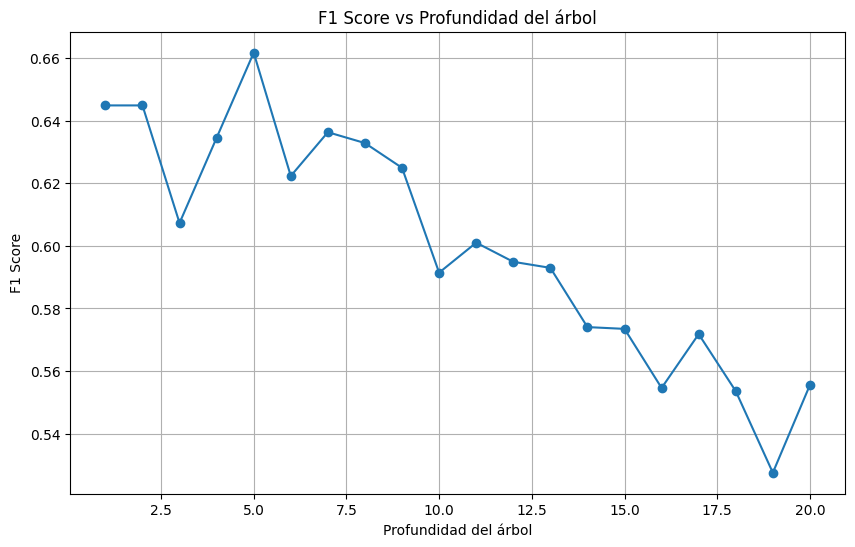

Profundidad óptima del árbol usando F1 Score: 5


In [118]:
# Gráfico de F1 score vs profundidad
plt.figure(figsize=(10, 6))
plt.plot(depths, f1_scores, marker='o')
plt.title('F1 Score vs Profundidad del árbol')
plt.xlabel('Profundidad del árbol')
plt.ylabel('F1 Score')
plt.grid()
plt.show()
# Profundidad óptima del árbol
optimal_depth_F1 = depths[np.argmax(f1_scores)]
print(f'Profundidad óptima del árbol usando F1 Score: {optimal_depth_F1}')

Se selecciona la profundidad óptima sugerida por el F1 Score y se procede con el entramiento y evaluación del modelo:

In [163]:
# Entrenamiento del árbol de decisión con profundidad óptima
model = DecisionTreeClassifier(max_depth=optimal_depth_F1, min_samples_split=2, min_samples_leaf=1, random_state=0)
model.fit(X_train, y_train)

# Predicciones con el árbol de decisión
y_pred = model.predict(X_test)

# Evaluación del árbol de decisión
Accuracy_DecisionTree = accuracy_score(y_test, y_pred)
F1_DecissionTree = f1_score(y_test, y_pred)
print(f'Accuracy del árbol de decisión: {Accuracy_DecisionTree:.4f}')
print(f'F1 score del árbol de decisión: {F1_DecissionTree:.4f}')

Accuracy del árbol de decisión: 0.6373
F1 score del árbol de decisión: 0.6617


### 6.2. Regresión Logística

En este punto se entrena un modelo de regresión logística con un máximo de 1000 iteraciones para asegurar su convergencia. Utilizando los datos de entrenamiento, se ajusta el modelo y luego se realizan predicciones sobre el conjunto de prueba. Finalmente, se evalúa su desempeño mediante las métricas de accuracy y F1-score para clasificación:

In [165]:
# Entrenamiento del modelo de regresión logística
model_logistic = LogisticRegression(max_iter=1000, random_state=0)
model_logistic.fit(X_train, y_train)

# Predicciones con el modelo de regresión logística
y_pred_logistic = model_logistic.predict(X_test)

# Evaluación del modelo de regresión logística
Accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
F1_logistic = f1_score(y_test, y_pred_logistic)
print(f'Accuracy del modelo de regresión logística: {Accuracy_logistic:.4f}')
print(f'F1 Score del modelo de regresión logística: {F1_logistic:.4f}')

Accuracy del modelo de regresión logística: 0.6153
F1 Score del modelo de regresión logística: 0.6034


### 6.3. Comparación de Desempeño y Conclusiones

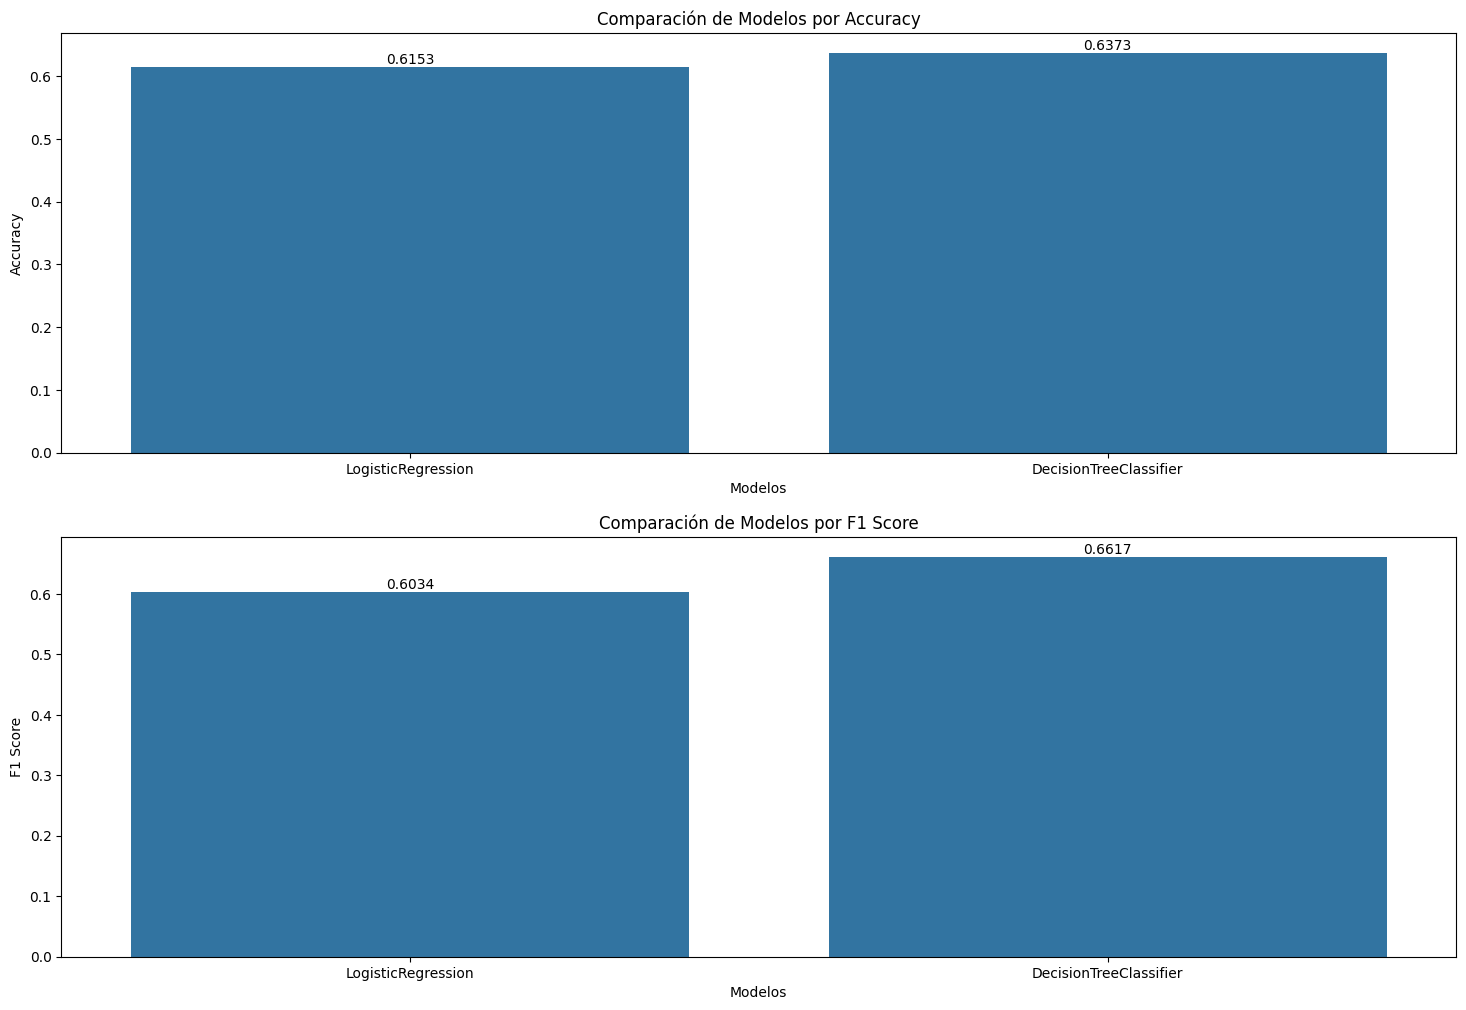

In [166]:
modelos = ['LogisticRegression', 'DecisionTreeClassifier']
Accuracy_scores = [Accuracy_logistic, Accuracy_DecisionTree]
F1_scores = [F1_logistic, F1_DecissionTree]

# Crear subplots
fig, axs = plt.subplots(2, 1, figsize=(18, 12))

# Gráfico 1: Comparar modelos por Accuracy
sns.barplot(x=modelos, y=Accuracy_scores, ax=axs[0])
axs[0].set_title('Comparación de Modelos por Accuracy')
axs[0].set_xlabel('Modelos')
axs[0].set_ylabel('Accuracy')
for i in range(len(modelos)):
    axs[0].text(i, Accuracy_scores[i], round(Accuracy_scores[i], 4), ha='center', va='bottom')

# Gráfico 2: Comparar modelos por F1
sns.barplot(x=modelos, y=F1_scores, ax=axs[1])
axs[1].set_title('Comparación de Modelos por F1 Score')
axs[1].set_xlabel('Modelos')
axs[1].set_ylabel('F1 Score')
for i in range(len(modelos)):
    axs[1].text(i, F1_scores[i], round(F1_scores[i], 4), ha='center', va='bottom')

**Conclusiones** <br>
<p style="text-align: justify;">
Al comprar el desempeño de los modelos LogisticRegression y DecisionTreeClassifier. El árbol de decisión presenta un mejor rendimiento en ambas métricas, con un accuracy de 0.6373 y un F1-score de 0.6617, superando a la regresión logística, que obtuvo 0.6153 en accuracy y 0.6034 en F1-score. Esto sugiere que el árbol predice con mayor precisión las clases de la variable Popular. <p>

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

### 7.1. Entrenamiento y Evaluación de Modelos

In [129]:
# Creación de 300 muestras bagged
n_estimators = 300
np.random.seed(123)
n_samples = X_train.shape[0]
samples = [np.random.choice(n_samples, n_samples, replace=True) for _ in range(n_estimators)]

In [130]:
# Validacion dimensional
len(samples), len(samples[0]), samples[0].shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

(300, 4500, (4500,), (4500, 59), (4500,), (1500, 59), (1500,))

#### 7.1.1. Arbol de Decisión max_depth

In [ ]:
# Entrenamiento y evaluación de arbol de decisión con primeras 100 muestras (definicion de max_depth=5)
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=100)
trees_max_depth = []
for i in range(100):
    model = DecisionTreeClassifier(max_depth=5, random_state=seeds[i])
    model.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    trees_max_depth.append(model)

# Prediccion para los datos de prueba
predictions_max_depth = pd.DataFrame(index=X_test.index, columns=range(100))
for i in range(100):
    predictions_max_depth.iloc[:, i] = trees_max_depth[i].predict(X_test)

# Votación mayoritaria max_depth
pred_max_depth = (predictions_max_depth.sum(axis=1) >= 50).astype(int)

# Evaluación del modelo max_depth
Accuracy_max_depth = accuracy_score(y_test, pred_max_depth)
F1_max_depth = f1_score(y_test, pred_max_depth)

In [68]:
# Resultados de arboles de decisión con max_depth
print(f'Accuracy del modelo bagged max_depth: {Accuracy_max_depth:.4f}')
print(f'F1 del modelo bagged max_depth: {F1_max_depth:.4f}')

Accuracy del modelo bagged max_depth: 0.6547
F1 del modelo bagged max_depth: 0.6528


#### 7.1.2. Arbol de Decisión min_sample_leaf

In [133]:
# Entrenamiento y evaluación de arbol de decisión segundas 100 muestras (definicion de min_sample_leaf=10)
trees_sample_leaf = []
for i in range(100, 200):
    model = DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
    model.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    trees_sample_leaf.append(model)

# Prediccion para los datos de prueba
predictions_sample_leaf = pd.DataFrame(index=X_test.index, columns=range(100))
for i in range(100):
    predictions_sample_leaf.iloc[:, i] = trees_sample_leaf[i].predict(X_test)

# Votación mayoritaria max_depth
pred_sample_leaf = (predictions_sample_leaf.sum(axis=1) >= 50).astype(int)
# Evaluación del modelo max_depth
Accuracy_sample_leaf = accuracy_score(y_test, pred_sample_leaf)
F1_sample_leaf = f1_score(y_test, pred_sample_leaf)

In [134]:
# Resultados del modelo bagged min_samples_leaf
print(f'Accuracy del modelo bagged min_samples_leaf: {Accuracy_sample_leaf:.4f}')
print(f'F1 del modelo bagged min_samples_leaf: {F1_sample_leaf:.4f}')

Accuracy del modelo bagged min_samples_leaf: 0.6507
F1 del modelo bagged min_samples_leaf: 0.6511


#### 7.1.3. Rgresión Logística

In [135]:
# Entrenamiento y evaluación de un modelo de regresión logística en terceras 100 muestras
logistic_reg = []
for i in range(200, 300):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    logistic_reg.append(model)

# Prediccion para los datos de prueba
predictions_logistic = pd.DataFrame(index=X_test.index, columns=range(100))
for i in range(100):
    predictions_logistic.iloc[:, i] = logistic_reg[i].predict(X_test)

# Votación mayoritaria max_depth
pred_logistic = (predictions_logistic.sum(axis=1) >= 50).astype(int)
# Evaluación del modelo max_depth
Accuracy_logistic = accuracy_score(y_test, pred_logistic)
F1_logistic = f1_score(y_test, pred_logistic)

In [136]:
# Resultados del modelo bagged logistic
print(f'Accuracy del modelo bagged logistic: {Accuracy_logistic:.4f}')
print(f'F1 del modelo bagged logistic: {F1_logistic:.4f}')

Accuracy del modelo bagged logistic: 0.6153
F1 del modelo bagged logistic: 0.6023


#### 7.1.4. Ensamble de Modelos

In [137]:
# Ensamble de los tres modelos
predictions_ensemble = pd.DataFrame(index=X_test.index, columns=range(300))
predictions_ensemble.iloc[:, :100] = predictions_max_depth
predictions_ensemble.iloc[:, 100:200] = predictions_sample_leaf
predictions_ensemble.iloc[:, 200:] = predictions_logistic

# Votación mayoritaria sobre las 300 predicciones
pred_ensemble = (predictions_ensemble.sum(axis=1) >= 150).astype(int)

# Evaluación del modelo
Accuracy_ensemble = accuracy_score(y_test, pred_ensemble)
F1_ensemble = f1_score(y_test, pred_ensemble)

In [138]:
# Resultados del modelo de ensamble
print(f'Accuracy del modelo de ensamble: {Accuracy_ensemble:.4f}')
print(f'F1 del modelo de ensamble: {F1_ensemble:.4f}')

Accuracy del modelo de ensamble: 0.6380
F1 del modelo de ensamble: 0.6278


### 7.2. Comparación de Modelos

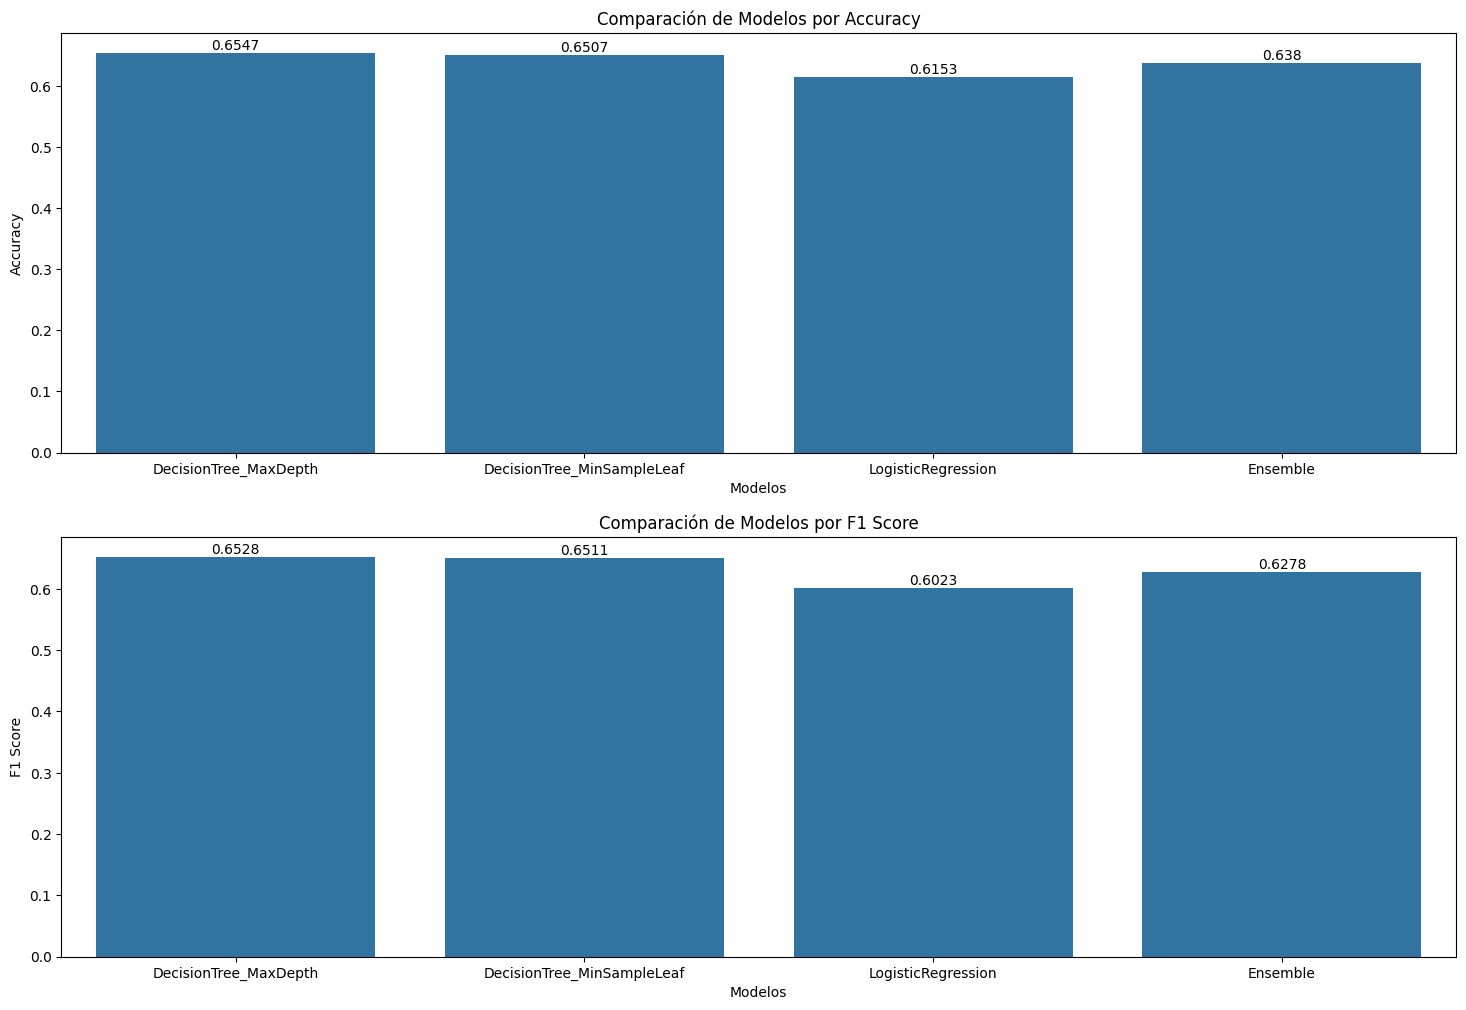

In [139]:
modelos = ['DecisionTree_MaxDepth', 'DecisionTree_MinSampleLeaf', 'LogisticRegression', 'Ensemble']
Accuracy_scores = [Accuracy_max_depth, Accuracy_sample_leaf, Accuracy_logistic, Accuracy_ensemble]
F1_scores = [F1_max_depth, F1_sample_leaf, F1_logistic, F1_ensemble]

# Crear subplots
fig, axs = plt.subplots(2, 1, figsize=(18, 12))

# Gráfico 1: Comparar modelos por Accuracy
sns.barplot(x=modelos, y=Accuracy_scores, ax=axs[0])
axs[0].set_title('Comparación de Modelos por Accuracy')
axs[0].set_xlabel('Modelos')
axs[0].set_ylabel('Accuracy')
for i in range(len(modelos)):
    axs[0].text(i, Accuracy_scores[i], round(Accuracy_scores[i], 4), ha='center', va='bottom')

# Gráfico 2: Comparar modelos por F1
sns.barplot(x=modelos, y=F1_scores, ax=axs[1])
axs[1].set_title('Comparación de Modelos por F1 Score')
axs[1].set_xlabel('Modelos')
axs[1].set_ylabel('F1 Score')
for i in range(len(modelos)):
    axs[1].text(i, F1_scores[i], round(F1_scores[i], 4), ha='center', va='bottom')

**Conclusiones**
<p style="text-align: justify;">
Se evaluaron tres conjuntos de modelos (árboles de decisión con max_depth=5, árboles con min_samples_leaf=10 y regresiones logísticas) y un ensamblado de los 300 clasificadores mediante votación mayoritaria. Los árboles con profundidad limitada obtuvieron el mejor rendimiento individual con una accuracy de 0.6547 y un F1 Score de 0.6528, seguidos por los árboles con min_samples_leaf=10. Las regresiones logísticas mostraron el rendimiento más bajo, con valores de 0.6153 en accuracy y 0.6023 en F1. El ensemble alcanzó una accuracy de 0.6380 y un F1 Score de 0.6278, situándose por debajo de los mejores modelos individuales. Esto sugiere que, si bien el ensamblado puede aportar robustez al integrar diferentes modelos, su efectividad depende de la calidad de los clasificadores que lo componen. La inclusión de modelos más débiles, como las regresiones logísticas en este caso, puede reducir el beneficio esperado del ensemble. Ajustes adicionales como votación ponderada o técnicas como stacking podrían mejorar los resultados. <p>

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Consolidación de los modelos en un diccionario
models = {}
for i in range(300):  # Suponiendo que tienes 300 modelos en total
    if i < 100:  # Primeros 100 modelos: DecisionTreeClassifier con max_depth=5
        models[i] = DecisionTreeClassifier(max_depth=5, random_state=seeds[i])
    elif i < 200:  # Siguientes 100 modelos: DecisionTreeClassifier con min_samples_leaf=10
        models[i] = DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
    else:  # Últimos 100 modelos: LogisticRegression
        models[i] = LogisticRegression(max_iter=1000, random_state=42)

# Validación de la longitud del diccionario de modelos
print(f"Longitud de diccionario de modelos: {len(models)}")

Longitud de diccionario de modelos: 300


In [ ]:
# Obtención de las obervaciones fuera de la bolsa (OOB) para cada modelo
samples_oob = []
for samples in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(samples)))

In [ ]:
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)
for i in range(n_estimators):
    # Ensure the model is fitted before prediction
    models[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    y_pred_ = models[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

In [ ]:
# Obtención de los pesos alpha de cada modelo de acuerdo con el error OOB
alpha = (1 - errors) / (1 - errors).sum()

In [ ]:
# Ponderación de las predicciones con los pesos alpha
weighted_sum = ((predictions_ensemble) * alpha).sum(axis=1)
weighted_sum.head(20)

In [ ]:
# Evaluación del desempeño al hacer votación ponderada
y_pred = (weighted_sum >= 0.5).astype(np.int64)
Accuracy_weigthed_ensemble = metrics.accuracy_score(y_pred, y_test)
F1_weighted_ensemble = metrics.f1_score(y_pred, y_test)

In [147]:
# Visualizacióon de resultados
print(f'Accuracy del modelo de ensamble ponderado: {Accuracy_weigthed_ensemble:.4f}')
print(f'F1 del modelo de ensamble ponderado: {F1_weighted_ensemble:.4f}')

Accuracy del modelo de ensamble ponderado: 0.6347
F1 del modelo de ensamble ponderado: 0.6241


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

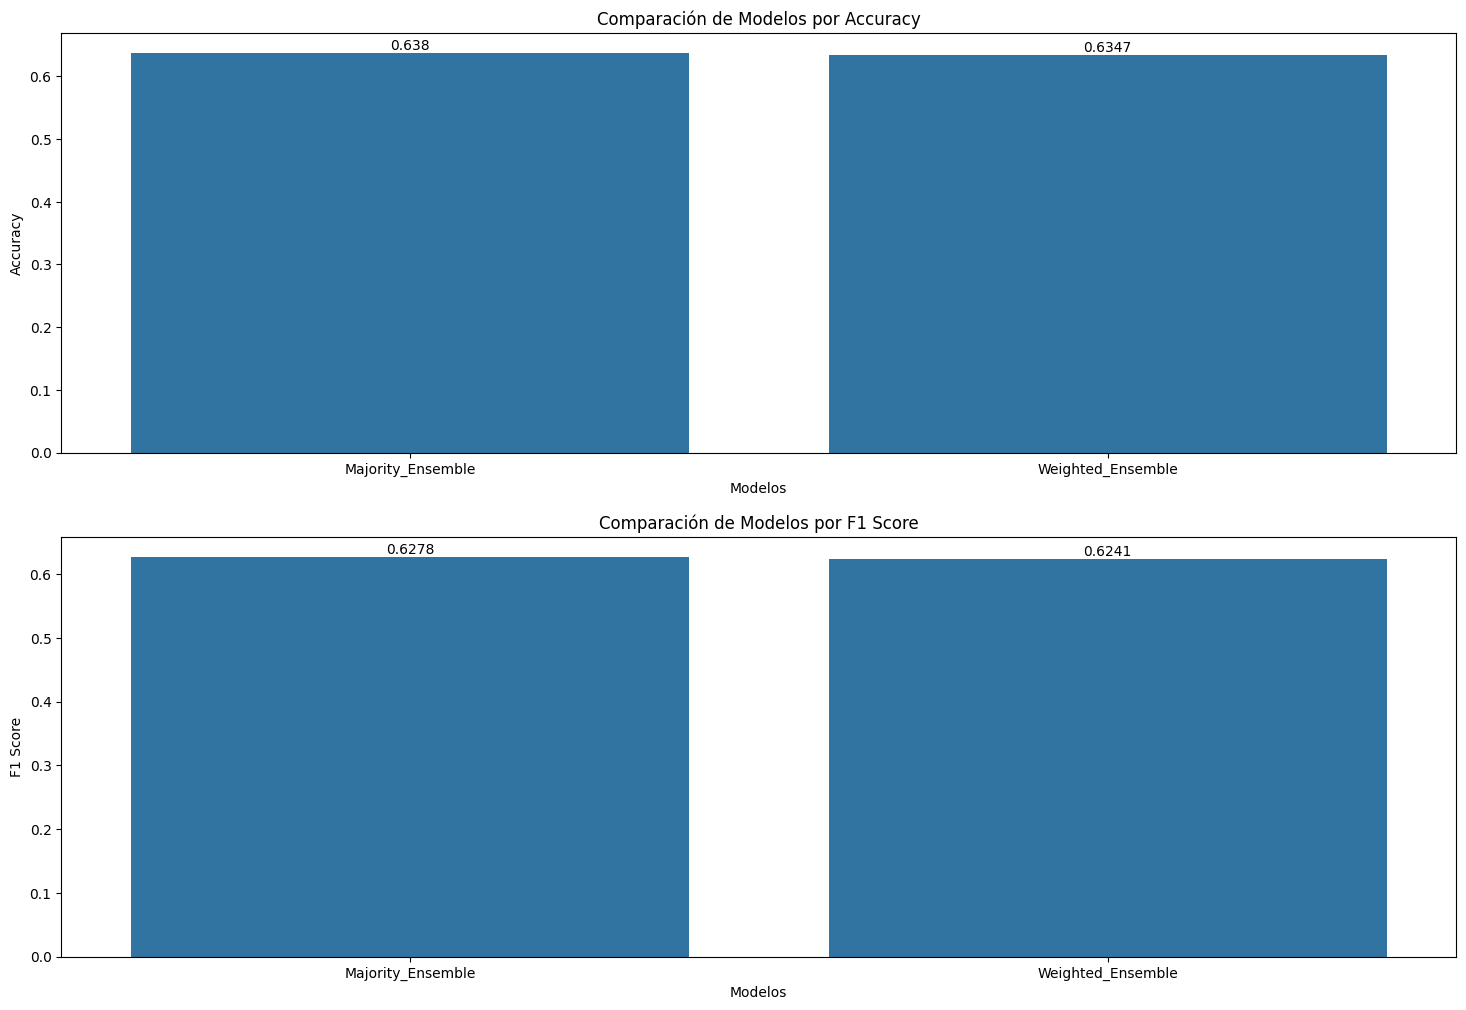

In [152]:
modelos = ['Majority_Ensemble', 'Weighted_Ensemble']
Accuracy_scores = [Accuracy_ensemble, Accuracy_weigthed_ensemble]
F1_scores = [F1_ensemble, F1_weighted_ensemble]

# Crear subplots
fig, axs = plt.subplots(2, 1, figsize=(18, 12))

# Gráfico 1: Comparar modelos por Accuracy
sns.barplot(x=modelos, y=Accuracy_scores, ax=axs[0])
axs[0].set_title('Comparación de Modelos por Accuracy')
axs[0].set_xlabel('Modelos')
axs[0].set_ylabel('Accuracy')
for i in range(len(modelos)):
    axs[0].text(i, Accuracy_scores[i], round(Accuracy_scores[i], 4), ha='center', va='bottom')

# Gráfico 2: Comparar modelos por F1
sns.barplot(x=modelos, y=F1_scores, ax=axs[1])
axs[1].set_title('Comparación de Modelos por F1 Score')
axs[1].set_xlabel('Modelos')
axs[1].set_ylabel('F1 Score')
for i in range(len(modelos)):
    axs[1].text(i, F1_scores[i], round(F1_scores[i], 4), ha='center', va='bottom')

**Conclusiones**
<p style="text-align: justify;">
Al comparar el desempeño de los modelos de ensablado con votación mayoritaria vs votación ponderada (Weighted_Ensemble), se observa que en términos de accuracy y F1-score, ambos modelos muestran un rendimiento muy similar, con una ligera ventaja para el modelo Ensemble no ponderado (0.638 vs 0.6347 en accuracy y 0.6278 vs 0.6241 en F1). Esta diferencia marginal sugiere que la incorporación de ponderaciones en el ensamblado no generó mejoras sustanciales. <p>

**Ventajas y Desventajas**
<p style="text-align: justify;">
El ensamblado con votación mayoritatia presenta ventajas como su facilidad de implementación, menor riesgo de sobreajuste, aunque trata a todos los modelos por igual, lo cual es una desventaja en los casos en los que algún modelo tenga un desempeño deficiente. Por su parte, el ensamblado con votación ponderada permite ajustar la influencia de cada modelo según su calidad, con potencial de mayor precisión, pero a costa de un poco más de complejidad y mayor sensibilidad a la selección de pesos. Esto último es importante dado que existen diferentes formas de definir los pesos, por ejemplo en la solución de este taller se definieron los pesos según los errores OOB.<p>